In [1]:
# ローカルの関数を修正したら即時反映するようにする
%load_ext autoreload
%autoreload 2

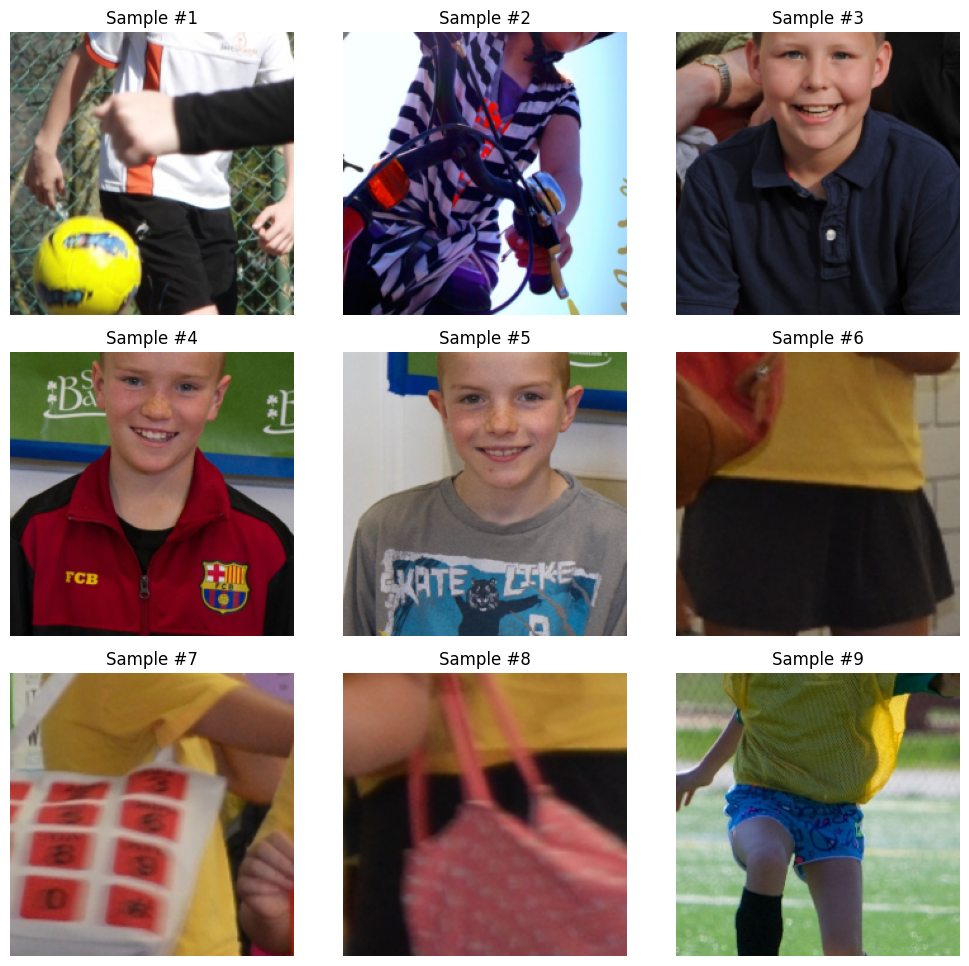

In [4]:
# datasetの表示
import matplotlib.pyplot as plt
from src.data.lagenda import LagendaDataset
from src.data.transform import get_transforms

transform = get_transforms()
dataset = LagendaDataset(csv_file='data/lagenda_annotation.csv', root_dir='data', crop_type="person", transform=transform)

fig = plt.figure(figsize=(10, 10))
for i in range(1, 10):
    sample = dataset[i]
    ax = plt.subplot(3, 3, i)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].permute(1, 2, 0) * 255)

In [5]:
import torch
from src.models.cvae import CVAE  # モデルのクラス

# パラメータ設定
input_channels = 3  # RGB画像
latent_dim = 64
conditional_dim = 2
img_size = 224

# モデルのインスタンス化と重みの読み込み
model = CVAE(input_channels, img_size, latent_dim, conditional_dim)
model.load_state_dict(torch.load('trained_model.pth'))
model.to('mps')  # CPUで推論する場合
model.eval()  # 推論モードに設定


CVAE(
  (encoder): Sequential(
    (0): Conv2d(5, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=50176, out_features=64, bias=True)
  (fc_var): Linear(in_features=50176, out_features=64, bias=True)
  (decoder_input): Linear(in_features=66, out_features=50176, bias=True)
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(256, 14, 14))
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2),

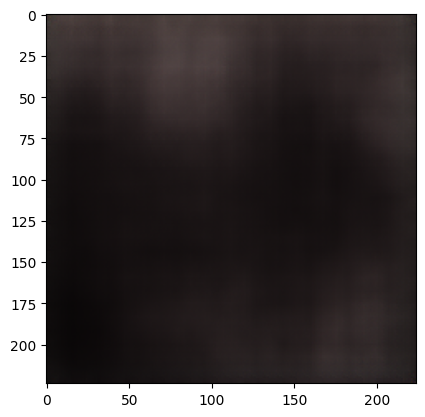

In [6]:
# 潜在変数のサンプリング
z = torch.randn(1, latent_dim).to("mps")  # ランダムな潜在変数
c = torch.tensor([[0.8, 1]]).to("mps")  # 条件変数（例: 性別、年齢など）

# 画像の生成
with torch.no_grad():
    generated_img = model.decode(z, c)
plt.imshow(generated_img[0].cpu().permute(1, 2, 0) * 255)

In [8]:
import torch
import plotly.express as px
import plotly.graph_objects as go
from src.data.lagenda import LagendaDataset
from src.data.transform import get_transforms

model.to('mps')

# データセットの読み込みと潜在変数の抽出
# 例えば dataset がデータセットのインスタンスであるとする
latent_variables = []
ages = []
genders = []
images = []

transfrom = get_transforms()
dataset = LagendaDataset(csv_file='data/lagenda_annotation.csv', root_dir='data/', crop_type="person", transform=transfrom)
for data in dataset:
    image, age, gender = data['image'], data['age'], data['gender']
    image = image.to('mps')
    conditions = torch.tensor([[age, gender]]).to('mps')

    with torch.no_grad():
        z, _ = model.encode(image.unsqueeze(0), conditions)
    latent_variables.append(z.squeeze(0).cpu().numpy())
    ages.append(age)
    genders.append('男性' if gender == 0 else '女性')
    images.append(image)


In [18]:
import numpy as np
np.save('latent_variables_face.npy', z.cpu().numpy())

In [16]:
# 潜在変数の可視化
scatter_data = {
    "x": [z[0] for z in latent_variables],
    "y": [z[1] for z in latent_variables],
    "age": ages,
    "gender": genders,
}

fig = px.scatter(
    scatter_data, x='x', y='y', color='gender', text='age',
    hover_data=['age', 'gender'], title='潜在変数の散布図'
)
fig.show()

In [9]:
import numpy as np
from sklearn.manifold import TSNE

# t-SNEで2次元に削減
tsne = TSNE(n_components=2)
latent_2d_tsne = tsne.fit_transform(np.array(latent_variables))

scatter_data = {
    "x": [z[0] for z in latent_2d_tsne],
    "y": [z[1] for z in latent_2d_tsne],
    "age": ages,
    "gender": genders,
}

fig = px.scatter(
    scatter_data, x='x', y='y', color='gender', text='age',
    hover_data=['age', 'gender'], title='潜在変数の散布図'
)
fig.show()